In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installing required external libraries

In [ ]:
pip install contractions emoji simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing required libraries

In [ ]:
import pandas as pd
import numpy as np
import string
import regex as re
import contractions
import emoji
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel, ClassificationModel, ClassificationArgs
import seaborn as sns
import matplotlib.pyplot as plt   
import wandb
import logging
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import torch

### Loading data from google drive

In [ ]:
train_data = pd.read_csv("/content/drive/My Drive/Sarcasm data/train/train.En.csv", sep=",")
test_data = pd.read_csv("/content/drive/My Drive/Sarcasm data/test/task_A_En_test.csv", sep=",")

In [ ]:
test_data.shape

(1400, 2)

In [ ]:
test_data[test_data.isna().any(axis=1)]

,text,sarcastic


In [ ]:
train_data.shape

(3468, 10)

In [ ]:
train_data.tail(5)

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
3463,3463,The population spike in Chicago in 9 months is...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3464,3464,You'd think in the second to last English clas...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3465,3465,I’m finally surfacing after a holiday to Scotl...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3466,3466,Couldn't be prouder today. Well done to every ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3467,3467,Overheard as my 13 year old games with a frien...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Extracting sarcastic data rows from train data

In [ ]:
train_sarcasm = train_data[train_data["sarcastic"] == 1]

### Extracting NON - sarcastic data rows from train data

In [ ]:
train_non_sarcasm = train_data[train_data["sarcastic"] == 0]

In [ ]:
train_sarcasm

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
862,862,yo @claires do yall do hysterectomies?,1,"Claires, you should not do full hysterectomies.",1.0,0.0,0.0,0.0,0.0,1.0
863,863,@JacobWohlReport Do I need to aquire a wife be...,1,A lot of people don't have a wife.,1.0,0.0,0.0,0.0,0.0,1.0
864,864,I get a lot of boy who cried wolf vibes from t...,1,The red cross is always needy.,0.0,1.0,0.0,0.0,0.0,0.0
865,865,Update: holding hands with your mom and walkin...,1,Holding hands with your parent while walking a...,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_sarcasm.sarcastic.unique()

array([1])

In [ ]:
train_sarcasm[train_sarcasm.isna().any(axis=1)]

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question


In [ ]:
train_non_sarcasm.head(5)

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
867,867,I always think going braless is a good idea un...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
868,868,life is so much better with a heating blanket,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
869,869,Sometimes I just go through my phone and look ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
870,870,was not back in the states for even 5 minutes ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
871,871,in desperate need of (and I can NOT stress thi...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_non_sarcasm = train_non_sarcasm[["tweet", "sarcastic"]]

In [ ]:
train_non_sarcasm.head(5)

,tweet,sarcastic
867,I always think going braless is a good idea un...,0
868,life is so much better with a heating blanket,0
869,Sometimes I just go through my phone and look ...,0
870,was not back in the states for even 5 minutes ...,0
871,in desperate need of (and I can NOT stress thi...,0


### Checking for NAN/null value rows

In [ ]:
train_non_sarcasm[train_non_sarcasm.isna().any(axis=1)]

,tweet,sarcastic
1062,NaN,0


### Dropping rows with NA values

In [ ]:
train_non_sarcasm = train_non_sarcasm.dropna()


In [ ]:
train_non_sarcasm[train_non_sarcasm.isna().any(axis=1)]

,tweet,sarcastic


In [ ]:
# irony	satire	understatement	overstatement	rhetorical_question
irony_count = int(train_sarcasm["irony"].sum())
satire_count = int(train_sarcasm["satire"].sum())
understatement_count = int(train_sarcasm["understatement"].sum())
overstatement_count = int(train_sarcasm["overstatement"].sum())
rhetorical_question_count = int(train_sarcasm["rhetorical_question"].sum())
print("irony - ", irony_count)
print("satire - ", satire_count)
print("understatement - ", understatement_count)
print("overstatement - ", overstatement_count)
print("rhetorical_question - ", rhetorical_question_count)

irony -  155
satire -  25
understatement -  10
overstatement -  40
rhetorical_question -  101


In [ ]:
train_data_task_A = pd.concat([ train_sarcasm[["tweet", "sarcastic"]], train_non_sarcasm], axis=0)


In [ ]:
train_data_task_A.sarcastic.unique

<bound method Series.unique of 0       1
1       1
2       1
3       1
4       1
       ..
3463    0
3464    0
3465    0
3466    0
3467    0
Name: sarcastic, Length: 3467, dtype: int64>

In [ ]:
train_data_task_A['sarcastic'].value_counts()

0    2600
1     867
Name: sarcastic, dtype: int64

## Preprocessing

### Expanding hashtags and splitting camel cased text

In [ ]:
def expand_hashtags ( sentences):
        hashtag_pattern = re.compile (r'#([\p{L}0-9\_]+)')
        return sentences.apply (lambda x: re.sub (hashtag_pattern, lambda match: camel_case_split (match.group (1)), x))

def camel_case_split ( identifier):
        # link https://stackoverflow.com/questions/29916065/how-to-do-camelcase-split-in-python/29920015
        
        matches = re.finditer ('.+?(?:(?<=\p{Ll})(?=\p{Lu})|(?<=\p{Lu})(?=\p{Lu}\p{Ll})|[0-9]+|$)', identifier)
        return ' '.join ([m.group (0) for m in matches])

### Expanding contactions like soooo...., whyyyyyy

In [ ]:
def expand_contractions(text):
    return contractions.fix(text)

### removing URLs

In [ ]:
def remove_links(s):
    removeLinksPattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',re.DOTALL)
    tmp = re.sub(removeLinksPattern, ' ', s)#, flags = re.DOTALL)
    return tmp 

### Removing name mentions

In [ ]:
def remove_mentions(text):
    begining_mentions_pattern = re.compile (r"^(@[A-Za-z0-9\_]+\s?)+")
    middle_mentions_pattern = re.compile (r'(?<!\b)@([A-Za-z0-9\_]+)\b(?<!user)')
    txt = text.apply (lambda x: re.sub (begining_mentions_pattern, '', x))
    return txt

### Removing percentages

In [ ]:
def remove_percentages(text):
    percents_pattern = re.compile(r"\b(\d+[\.,]?\d*|\d{2}[AP]M)%")
    #percents_pattern = re.compile(r"(\d+(\.\d+)?%)")
    return text.apply (lambda x: re.sub(percents_pattern, ' ', x))#   re.findall(percents_pattern, text)

def check_percentages(text):
    percents_pattern = re.compile(r"\b(\d+[\.,]?\d*|\d{2}[AP]M)%")
    #percents_pattern = re.compile(r"(\d+(\.\d+)?%)")
    return text.apply (lambda x: re.findall(percents_pattern,  x))#   re.findall(percents_pattern, text)

### Removing digits

In [ ]:
def remove_digits (text, replace = '[NUMERO]'):
        digits_pattern = re.compile (r"\b(\d+[\.,]?\d*|\d{2}[AP]M)\b")
        return text.apply (lambda x: re.sub (digits_pattern, replace, x))

In [ ]:
# link https://stackoverflow.com/questions/24893977/whats-the-best-way-to-regex-replace-a-string-in-python-but-keep-its-case
def replace_keep_case (word, replacement, text):
    def func (match):
        g = match.group ()
        if g.islower (): return replacement.lower ()
        if g.istitle (): return replacement.title ()
        if g.isupper (): return replacement.upper ()
        return replacement
    return re.sub (word, func, text)

def remove_elongations (text):
        laughs_pattern = re.compile (r'(?i)\b(mua)?j[ja]+a?\b')
        # Remove laughs
        txt = text.apply (lambda x: re.sub (laughs_pattern, 'jajaja', x))

        
        # Remove exclamatory and interrogative
        for character in ['!', '¡', '?', '¿']:
            pattern = re.compile ('\\' + character + '{2,}')
            txt = txt.apply (lambda x: re.sub (pattern, character, x))
        
        # Add (.)\1{2,}|[aá]{2,}|[eé]{2,}|[ií]{2,}|[oó]{2,}|[uú]{2,})
        elongation_pattern = re.compile (r'(.)\1{2,}')
        # Remove letters longer than 2
        txt = txt.apply (lambda x: re.sub (elongation_pattern, r'\1', x))
        
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[aá]{2,}'), "á", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[eé]{2,}'), "é", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[ií]{2,}'), "í", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[oó]{2,}'), "ó", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[uú]{2,}'), "ú", x))
        return txt

In [ ]:
def remove_emojis (text):
        return text.apply (lambda x: emoji.get_emoji_regexp ().sub (u'', x))

In [ ]:
def remove_quotations (text):
        quotations_pattern = r'["“”\'«»‘’]'
        return text.replace (to_replace = quotations_pattern, value = '', regex = True)

In [ ]:
def remove_punctuation (text):
    punctuation_pattern = re.compile ("[" + re.escape(string.punctuation) + "]")
    #print(punctuation_pattern)
    punc = text.apply (lambda x: re.findall(punctuation_pattern,  x))
    #print(punc)
    return text.apply (lambda x: re.sub (punctuation_pattern, '', x))

In [ ]:
def preprocessData(text):
  txt = expand_hashtags(text)
  txt = txt.apply(lambda x: expand_contractions(x))
  txt = txt.apply(lambda x: remove_links(x))
  txt = remove_mentions(txt)
  txt = remove_percentages(txt)
  txt = remove_digits(txt)
  txt = remove_elongations(txt)
  # txt = remove_emojis(txt)
  txt = txt.str.lower()
  txt = remove_quotations(txt)
  txt = remove_punctuation(txt)
  txt = txt.apply(lambda x: x.strip())
  return txt

In [ ]:
train_data_task_A.tweet = preprocessData(train_data_task_A.tweet)

test_data.text = preprocessData(test_data.text)


In [ ]:
train_data_task_A.head(5)

,tweet,sarcastic
0,the only thing i got from college is a caffein...,1
1,i love it when professors draw a big question ...,1
2,remember the hundred emails from companies whe...,1
3,today my poppop told me i was not forced to go...,1
4,i did tó and i also reported cancun cruz not w...,1


In [ ]:
test_data.head(5)

,text,sarcastic
0,size on the the toulouse team that pack is mon...,0
1,pinball,0
2,so the scottish government want people to get ...,1
3,villainous pro tip change the device name on ...,0
4,i would date any of these men 🥺,0


In [ ]:
train_data_task_A.shape

(3467, 2)

### Generating classification results stats

In [ ]:
def display_classification_stats(result):
  confusion_matrix = np.zeros((2,2))
  confusion_matrix[0][0] = result['tn']
  confusion_matrix[0][1] = result['fp']
  confusion_matrix[1][0] = result['fn']
  confusion_matrix[1][1] = result['tp']


  precision =  result['tp'] / ( result['tp'] + result['fp'] )
  recall = result['tp'] / ( result['tp'] + result['fn'] )
  F_score =  2 * precision * recall / (precision + recall)
  accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1])/np.sum(confusion_matrix)
  print("ACCURACY  : ", accuracy)
  print("PRECISION : ", precision)
  print("RECALL    : ", recall)
  print("F1        : ", F_score)

  # print(confusion_matrix)
  ax= plt.subplot()
  sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  #ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['non-sarcastic', 'sarcastic']); ax.yaxis.set_ticklabels(['non-sarcastic', 'sarcastic']);

### Loading model

In [ ]:
model = ClassificationModel( 'bertweet', 'vinai/bertweet-base', args={'train_batch_size':4, 'learning_rate': 3e-5, 'num_train_epochs': 2, 'max_seq_length': 512, 'overwrite_output_dir': True})


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

### Training...

In [ ]:
model.train_model(train_data_task_A)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3467 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/867 [00:00<?, ?it/s]

(1734, 0.5332949417272653)

In [ ]:
print(np.unique(test_data.sarcastic.values, return_counts=True))

(array([0, 1]), array([1200,  200]))


### Evaluatung on test data

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(test_data)

### Results

ACCURACY  :  0.78
PRECISION :  0.4106145251396648
RECALL    :  0.735
F1        :  0.5268817204301075


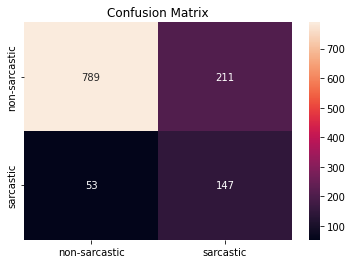

In [ ]:
display_classification_stats(result)

In [ ]:
torch.save(model, '/content/drive/My Drive/Sarcasm data/model_3_epochs_bertweet') 